# Just a little bit modification within missing analysis data and analysing the posthoc

In [44]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gmean, ttest_ind
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import f_oneway
import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm


# transcriptome
from statsmodels.formula.api import ols

In [2]:
proteome = pd.read_excel("/Users/mortezaabyadeh/Desktop/Proteomic.xlsx")

In [3]:
proteome.head()

,Master,Accession,Description,Coverage [%],Abundance Ratio: (Etoposide) / (Control),Abundance Ratio: (FTY720) / (Control),Abundance Ratio: (FTY720_plus_Etoposide) / (Control),# PSMs,# Peptides,# Unique Peptides,...,"Abundances (Normalized): F4: Sample, Etoposide","Abundances (Normalized): F5: Sample, Etoposide","Abundances (Normalized): F6: Sample, Etoposide","Abundances (Normalized): F10: Sample, FTY720","Abundances (Normalized): F11: Sample, FTY720","Abundances (Normalized): F12: Sample, FTY720","Abundances (Normalized): F7: Sample, FTY720_plus_Etoposide","Abundances (Normalized): F8: Sample, FTY720_plus_Etoposide","Abundances (Normalized): F9: Sample, FTY720_plus_Etoposide",Contaminant
0,Master Protein,P08670,Vimentin [OS=Homo sapiens],90,0.690,1.034,0.956,4919,73,65,...,1.194626e+10,8.138632e+09,8.359638e+09,1.037863e+10,1.260664e+10,1.303859e+10,1.286167e+10,1.279744e+10,1.327241e+10,False
1,Master Protein,Q09666,Neuroblast differentiation-associated protein ...,70,0.833,1.101,1.019,2991,269,268,...,1.772634e+09,2.325231e+09,2.399826e+09,2.122741e+09,2.138561e+09,2.067453e+09,1.941775e+09,2.051846e+09,1.983623e+09,False
2,Master Protein,P60709,"Actin, cytoplasmic 1 [OS=Homo sapiens]",94,0.687,0.955,0.888,2652,35,1,...,7.444967e+09,5.882621e+09,5.694489e+09,5.942383e+09,7.232767e+09,6.858702e+09,6.464013e+09,6.143735e+09,6.091506e+09,True
3,Master Protein,P63261,"Actin, cytoplasmic 2 [OS=Homo sapiens]",94,0.414,0.940,0.658,2651,35,1,...,1.120958e+06,1.139723e+06,1.601739e+06,3.598291e+06,1.953038e+06,6.898486e+05,1.758126e+06,1.617831e+06,1.715513e+06,False
4,Master Protein,P04406,Glyceraldehyde-3-phosphate dehydrogenase [OS=H...,76,0.364,0.755,0.755,2418,20,20,...,1.199184e+09,8.301472e+08,9.464704e+08,8.816873e+08,9.276548e+08,1.222988e+09,1.461613e+09,1.278716e+09,1.370481e+09,False


In [4]:
proteome.columns

Index(['Master', 'Accession', 'Description', 'Coverage [%]',
       'Abundance Ratio: (Etoposide) / (Control)',
       'Abundance Ratio: (FTY720) / (Control)',
       'Abundance Ratio: (FTY720_plus_Etoposide) / (Control)', '# PSMs',
       '# Peptides', '# Unique Peptides', '# Protein Unique Peptides',
       'MW [kDa]', 'Gene Symbol', 'Abundance: F1: Sample, Control',
       'Abundance: F2: Sample, Control', 'Abundance: F3: Sample, Control',
       'Abundance: F4: Sample, Etoposide', 'Abundance: F5: Sample, Etoposide',
       'Abundance: F6: Sample, Etoposide', 'Abundance: F10: Sample, FTY720',
       'Abundance: F11: Sample, FTY720', 'Abundance: F12: Sample, FTY720',
       'Abundance: F7: Sample, FTY720_plus_Etoposide',
       'Abundance: F8: Sample, FTY720_plus_Etoposide',
       'Abundance: F9: Sample, FTY720_plus_Etoposide',
       'Abundances (Normalized): F1: Sample, Control',
       'Abundances (Normalized): F2: Sample, Control',
       'Abundances (Normalized): F3: Sample, Co

In [5]:
control_cols = ["Abundances (Normalized): F1: Sample, Control", "Abundances (Normalized): F2: Sample, Control", "Abundances (Normalized): F3: Sample, Control"]
etoposide_cols = ["Abundances (Normalized): F4: Sample, Etoposide", "Abundances (Normalized): F5: Sample, Etoposide", "Abundances (Normalized): F6: Sample, Etoposide"]
fty_cols = ["Abundances (Normalized): F10: Sample, FTY720", "Abundances (Normalized): F11: Sample, FTY720", "Abundances (Normalized): F12: Sample, FTY720"]
fty_eto_cols = ["Abundances (Normalized): F7: Sample, FTY720_plus_Etoposide", "Abundances (Normalized): F8: Sample, FTY720_plus_Etoposide","Abundances (Normalized): F9: Sample, FTY720_plus_Etoposide"]

In [6]:
def filter_rows(row):
    control_nan_count = row[control_cols].isna().sum()
    eoposide_nan_count = row[etoposide_cols].isna().sum()
    fty_nan_count = row[fty_cols].isna().sum()
    ftyeto_nan_count = row[fty_eto_cols].isna().sum()
    return not ((control_nan_count > 2) or (eoposide_nan_count > 2) or (fty_nan_count > 2) or (ftyeto_nan_count > 2)) 

filtered_proteome = proteome[proteome.apply(filter_rows, axis=1)]

In [7]:
print(proteome.shape)
proteome.isna().sum()

(4525, 38)


Master                                                           0
Accession                                                        0
Description                                                      0
Coverage [%]                                                     0
Abundance Ratio: (Etoposide) / (Control)                       825
Abundance Ratio: (FTY720) / (Control)                          774
Abundance Ratio: (FTY720_plus_Etoposide) / (Control)           817
# PSMs                                                           0
# Peptides                                                       0
# Unique Peptides                                                0
# Protein Unique Peptides                                        0
MW [kDa]                                                         0
Gene Symbol                                                     32
Abundance: F1: Sample, Control                                1099
Abundance: F2: Sample, Control                                

In [8]:
print(filtered_proteome.shape)
filtered_proteome.isna().sum()

(3169, 38)


Master                                                          0
Accession                                                       0
Description                                                     0
Coverage [%]                                                    0
Abundance Ratio: (Etoposide) / (Control)                      152
Abundance Ratio: (FTY720) / (Control)                          62
Abundance Ratio: (FTY720_plus_Etoposide) / (Control)          142
# PSMs                                                          0
# Peptides                                                      0
# Unique Peptides                                               0
# Protein Unique Peptides                                       0
MW [kDa]                                                        0
Gene Symbol                                                    19
Abundance: F1: Sample, Control                                 59
Abundance: F2: Sample, Control                                 59
Abundance:

In [9]:
def impute_group(group):
    imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=0)
    imputed_group = imputer.fit_transform(group)
    return pd.DataFrame(imputed_group, columns=group.columns, index=group.index)

control_imputed = impute_group(filtered_proteome[control_cols])
filtered_proteome[control_cols] = control_imputed

etoposide_imputed = impute_group(filtered_proteome[etoposide_cols])
filtered_proteome[etoposide_cols] = etoposide_imputed

fty_imputed = impute_group(filtered_proteome[fty_cols])
filtered_proteome[fty_cols] = fty_imputed

fty_eto_imputed = impute_group(filtered_proteome[fty_eto_cols])
filtered_proteome[fty_eto_cols] = fty_eto_imputed

In [10]:
print(filtered_proteome.isna().sum())
print(filtered_proteome.shape)

Master                                                          0
Accession                                                       0
Description                                                     0
Coverage [%]                                                    0
Abundance Ratio: (Etoposide) / (Control)                      152
Abundance Ratio: (FTY720) / (Control)                          62
Abundance Ratio: (FTY720_plus_Etoposide) / (Control)          142
# PSMs                                                          0
# Peptides                                                      0
# Unique Peptides                                               0
# Protein Unique Peptides                                       0
MW [kDa]                                                        0
Gene Symbol                                                    19
Abundance: F1: Sample, Control                                 59
Abundance: F2: Sample, Control                                 59
Abundance:

In [11]:
filtered_proteome.columns

Index(['Master', 'Accession', 'Description', 'Coverage [%]',
       'Abundance Ratio: (Etoposide) / (Control)',
       'Abundance Ratio: (FTY720) / (Control)',
       'Abundance Ratio: (FTY720_plus_Etoposide) / (Control)', '# PSMs',
       '# Peptides', '# Unique Peptides', '# Protein Unique Peptides',
       'MW [kDa]', 'Gene Symbol', 'Abundance: F1: Sample, Control',
       'Abundance: F2: Sample, Control', 'Abundance: F3: Sample, Control',
       'Abundance: F4: Sample, Etoposide', 'Abundance: F5: Sample, Etoposide',
       'Abundance: F6: Sample, Etoposide', 'Abundance: F10: Sample, FTY720',
       'Abundance: F11: Sample, FTY720', 'Abundance: F12: Sample, FTY720',
       'Abundance: F7: Sample, FTY720_plus_Etoposide',
       'Abundance: F8: Sample, FTY720_plus_Etoposide',
       'Abundance: F9: Sample, FTY720_plus_Etoposide',
       'Abundances (Normalized): F1: Sample, Control',
       'Abundances (Normalized): F2: Sample, Control',
       'Abundances (Normalized): F3: Sample, Co

In [12]:
proteome = filtered_proteome.loc[:, [
    "Gene Symbol",
    'Abundances (Normalized): F1: Sample, Control',
    'Abundances (Normalized): F2: Sample, Control',
    'Abundances (Normalized): F3: Sample, Control',
    'Abundances (Normalized): F4: Sample, Etoposide',
    'Abundances (Normalized): F5: Sample, Etoposide',
    'Abundances (Normalized): F6: Sample, Etoposide',
    'Abundances (Normalized): F10: Sample, FTY720',
    'Abundances (Normalized): F11: Sample, FTY720',
    'Abundances (Normalized): F12: Sample, FTY720',
    'Abundances (Normalized): F7: Sample, FTY720_plus_Etoposide',
    'Abundances (Normalized): F8: Sample, FTY720_plus_Etoposide',
    'Abundances (Normalized): F9: Sample, FTY720_plus_Etoposide',
    'Contaminant'
]]

# columns_to_select = [
#    "Gene Symbol",
#    'Abundances (Normalized): F1: Sample, Control',
#    'Abundances (Normalized): F2: Sample, Control',
#    'Abundances (Normalized): F3: Sample, Control',
#    'Abundances (Normalized): F4: Sample, Etoposide',
#    'Abundances (Normalized): F5: Sample, Etoposide',
#    'Abundances (Normalized): F6: Sample, Etoposide',
#    'Abundances (Normalized): F10: Sample, FTY720',
#    'Abundances (Normalized): F11: Sample, FTY720',
#    'Abundances (Normalized): F12: Sample, FTY720',
#    'Abundances (Normalized): F7: Sample, FTY720_plus_Etoposide',
#    'Abundances (Normalized): F8: Sample, FTY720_plus_Etoposide',
#    'Abundances (Normalized): F9: Sample, FTY720_plus_Etoposide',
#   'Contaminant']

# proteome = filtered_proteome[columns_to_select]

In [13]:
print(proteome.isna().sum())

Gene Symbol                                                   19
Abundances (Normalized): F1: Sample, Control                   0
Abundances (Normalized): F2: Sample, Control                   0
Abundances (Normalized): F3: Sample, Control                   0
Abundances (Normalized): F4: Sample, Etoposide                 0
Abundances (Normalized): F5: Sample, Etoposide                 0
Abundances (Normalized): F6: Sample, Etoposide                 0
Abundances (Normalized): F10: Sample, FTY720                   0
Abundances (Normalized): F11: Sample, FTY720                   0
Abundances (Normalized): F12: Sample, FTY720                   0
Abundances (Normalized): F7: Sample, FTY720_plus_Etoposide     0
Abundances (Normalized): F8: Sample, FTY720_plus_Etoposide     0
Abundances (Normalized): F9: Sample, FTY720_plus_Etoposide     0
Contaminant                                                    0
dtype: int64


In [14]:
proteome = proteome.dropna(subset=["Gene Symbol"])

In [15]:
proteome.shape

(3150, 14)

In [16]:
proteome['Mean_CTRL'] = gmean(proteome[control_cols], axis=1)
proteome['Mean_Eto'] = gmean(proteome[etoposide_cols], axis=1)
proteome['Mean_FTY'] = gmean(proteome[fty_cols], axis=1)
proteome['Mean_FTY_Eto'] = gmean(proteome[fty_eto_cols], axis=1)

In [17]:
proteome["FC_Eto/CTRL"] = proteome['Mean_Eto']/proteome['Mean_CTRL']
proteome['log2_FC_Eto/CTRL'] = np.log2(proteome['FC_Eto/CTRL'])

proteome["FC_FTY/CTRL"] = proteome['Mean_FTY']/proteome['Mean_CTRL']
proteome['log2_FC_FTY/CTRL'] = np.log2(proteome['FC_FTY/CTRL'])

proteome["FC_FTY_Eto/CTRL"] = proteome['Mean_FTY_Eto']/proteome['Mean_CTRL']
proteome['log2_FC_FTY_Eto/CTRL'] = np.log2(proteome['FC_FTY_Eto/CTRL'])

proteome["FC_FTY/Eto"] = proteome['Mean_FTY']/proteome['Mean_Eto']
proteome['log2_FC_FTY/Eto'] = np.log2(proteome['FC_FTY/Eto'])

proteome["FC_FTY_Eto/Eto"] = proteome['Mean_FTY_Eto']/proteome['Mean_Eto']
proteome['log2_FC_FTY_Eto/Eto'] = np.log2(proteome['FC_FTY_Eto/Eto'])

proteome["FC_FTY_Eto/FTY"] = proteome['Mean_FTY_Eto']/proteome['Mean_FTY']
proteome['log2_FC_FTY_Eto/FTY'] = np.log2(proteome['FC_FTY_Eto/FTY'])

In [18]:
proteome.head()

,Gene Symbol,"Abundances (Normalized): F1: Sample, Control","Abundances (Normalized): F2: Sample, Control","Abundances (Normalized): F3: Sample, Control","Abundances (Normalized): F4: Sample, Etoposide","Abundances (Normalized): F5: Sample, Etoposide","Abundances (Normalized): F6: Sample, Etoposide","Abundances (Normalized): F10: Sample, FTY720","Abundances (Normalized): F11: Sample, FTY720","Abundances (Normalized): F12: Sample, FTY720",...,FC_FTY/CTRL,log2_FC_FTY/CTRL,FC_FTY_Eto/CTRL,log2_FC_FTY_Eto/CTRL,FC_FTY/Eto,log2_FC_FTY/Eto,FC_FTY_Eto/Eto,log2_FC_FTY_Eto/Eto,FC_FTY_Eto/FTY,log2_FC_FTY_Eto/FTY
0,VIM,1.649179e+10,1.661164e+10,1.524631e+10,1.194626e+10,8.138632e+09,8.359638e+09,1.037863e+10,1.260664e+10,1.303859e+10,...,0.741950,-0.430605,0.805703,-0.311680,1.280363,0.356552,1.390379,0.475478,1.085926,0.118926
1,AHNAK,2.003021e+09,1.849071e+09,1.713771e+09,1.772634e+09,2.325231e+09,2.399826e+09,2.122741e+09,2.138561e+09,2.067453e+09,...,1.139255,0.188090,1.075813,0.105428,0.982645,-0.025258,0.927924,-0.107921,0.944313,-0.082663
2,ACTB,5.672231e+09,5.636443e+09,5.878443e+09,7.444967e+09,5.882621e+09,5.694489e+09,5.942383e+09,7.232767e+09,6.858702e+09,...,1.161882,0.216463,1.087792,0.121403,1.057319,0.080411,0.989898,-0.014649,0.936233,-0.095060
3,ACTG1,2.238417e+06,2.190261e+06,2.738121e+06,1.120958e+06,1.139723e+06,1.601739e+06,3.598291e+06,1.953038e+06,6.898486e+05,...,0.712126,-0.489795,0.713667,-0.486676,1.333092,0.414776,1.335976,0.417895,1.002164,0.003118
4,GAPDH,1.242975e+09,1.282440e+09,1.185116e+09,1.199184e+09,8.301472e+08,9.464704e+08,8.816873e+08,9.276548e+08,1.222988e+09,...,0.809011,-0.305769,1.106810,0.146408,1.020137,0.028763,1.395653,0.480940,1.368103,0.452177


In [19]:
expression_data = proteome.iloc[:, 1:10]
genes = proteome.iloc[:, 0]
print(expression_data.head())

   Abundances (Normalized): F1: Sample, Control  \
0                                  1.649179e+10   
1                                  2.003021e+09   
2                                  5.672231e+09   
3                                  2.238417e+06   
4                                  1.242975e+09   

   Abundances (Normalized): F2: Sample, Control  \
0                                  1.661164e+10   
1                                  1.849071e+09   
2                                  5.636443e+09   
3                                  2.190261e+06   
4                                  1.282440e+09   

   Abundances (Normalized): F3: Sample, Control  \
0                                  1.524631e+10   
1                                  1.713771e+09   
2                                  5.878443e+09   
3                                  2.738121e+06   
4                                  1.185116e+09   

   Abundances (Normalized): F4: Sample, Etoposide  \
0                         

In [20]:
expression_data = proteome.iloc[:, 1:10]
genes = proteome.iloc[:, 0]


groups = [expression_data.iloc[:, i:i+3] for i in range(0, len(expression_data.columns), 3)]


P_Val = []
for i in range(len(expression_data)):
    data_i = pd.DataFrame(expression_data.iloc[i, :])  # Convert to DataFrame
    group_i = [data_i.iloc[j:j+3, :] for j in range(0, len(data_i), 3)]  # Access rows for each group
    p_value = f_oneway(*group_i)
    P_Val.append(p_value)


p_values_df = pd.DataFrame(P_Val, index=genes, columns=['F_value', 'p_value'])  # Adjusted to include F_value


print(p_values_df)

                          F_value                  p_value
Gene Symbol                                               
VIM          [14.061796499856634]    [0.00543612570756712]
AHNAK        [1.7640375647415338]    [0.24971132113926583]
ACTB         [1.5076497826418662]    [0.29479035108718127]
ACTG1         [1.267140157952302]    [0.34749858502481396]
GAPDH        [2.3121848680121535]    [0.18011265286899675]
...                           ...                      ...
BICC1         [8.121658433351493]   [0.019627053454329406]
OSBPL1A      [3.3089279713994175]     [0.1075219313609997]
ATXN3         [3.854482605582061]    [0.08383777195930091]
CLEC11A        [68.4960146866027]  [7.387853276846636e-05]
MECP2         [2.574457760566768]     [0.1558676103244947]

[3150 rows x 2 columns]


In [21]:
p_values_df.to_excel("/Users/mortezaabyadeh/Desktop/p_values.xlsx")

In [22]:
proteome.head()

,Gene Symbol,"Abundances (Normalized): F1: Sample, Control","Abundances (Normalized): F2: Sample, Control","Abundances (Normalized): F3: Sample, Control","Abundances (Normalized): F4: Sample, Etoposide","Abundances (Normalized): F5: Sample, Etoposide","Abundances (Normalized): F6: Sample, Etoposide","Abundances (Normalized): F10: Sample, FTY720","Abundances (Normalized): F11: Sample, FTY720","Abundances (Normalized): F12: Sample, FTY720",...,FC_FTY/CTRL,log2_FC_FTY/CTRL,FC_FTY_Eto/CTRL,log2_FC_FTY_Eto/CTRL,FC_FTY/Eto,log2_FC_FTY/Eto,FC_FTY_Eto/Eto,log2_FC_FTY_Eto/Eto,FC_FTY_Eto/FTY,log2_FC_FTY_Eto/FTY
0,VIM,1.649179e+10,1.661164e+10,1.524631e+10,1.194626e+10,8.138632e+09,8.359638e+09,1.037863e+10,1.260664e+10,1.303859e+10,...,0.741950,-0.430605,0.805703,-0.311680,1.280363,0.356552,1.390379,0.475478,1.085926,0.118926
1,AHNAK,2.003021e+09,1.849071e+09,1.713771e+09,1.772634e+09,2.325231e+09,2.399826e+09,2.122741e+09,2.138561e+09,2.067453e+09,...,1.139255,0.188090,1.075813,0.105428,0.982645,-0.025258,0.927924,-0.107921,0.944313,-0.082663
2,ACTB,5.672231e+09,5.636443e+09,5.878443e+09,7.444967e+09,5.882621e+09,5.694489e+09,5.942383e+09,7.232767e+09,6.858702e+09,...,1.161882,0.216463,1.087792,0.121403,1.057319,0.080411,0.989898,-0.014649,0.936233,-0.095060
3,ACTG1,2.238417e+06,2.190261e+06,2.738121e+06,1.120958e+06,1.139723e+06,1.601739e+06,3.598291e+06,1.953038e+06,6.898486e+05,...,0.712126,-0.489795,0.713667,-0.486676,1.333092,0.414776,1.335976,0.417895,1.002164,0.003118
4,GAPDH,1.242975e+09,1.282440e+09,1.185116e+09,1.199184e+09,8.301472e+08,9.464704e+08,8.816873e+08,9.276548e+08,1.222988e+09,...,0.809011,-0.305769,1.106810,0.146408,1.020137,0.028763,1.395653,0.480940,1.368103,0.452177


In [23]:
P = pd.read_excel("/Users/mortezaabyadeh/Desktop/p_values.xlsx")

In [24]:
P.head()

,Gene Symbol,F_value,p_value
0,VIM,[14.0617965],[0.00543613]
1,AHNAK,[1.76403756],[0.24971132]
2,ACTB,[1.50764978],[0.29479035]
3,ACTG1,[1.26714016],[0.34749859]
4,GAPDH,[2.31218487],[0.18011265]


In [25]:
print(P.shape)
print(proteome.shape)

(3150, 3)
(3150, 30)


In [26]:
proteome["ANOVA"] = P["p_value"]

In [27]:
proteome.head()

,Gene Symbol,"Abundances (Normalized): F1: Sample, Control","Abundances (Normalized): F2: Sample, Control","Abundances (Normalized): F3: Sample, Control","Abundances (Normalized): F4: Sample, Etoposide","Abundances (Normalized): F5: Sample, Etoposide","Abundances (Normalized): F6: Sample, Etoposide","Abundances (Normalized): F10: Sample, FTY720","Abundances (Normalized): F11: Sample, FTY720","Abundances (Normalized): F12: Sample, FTY720",...,log2_FC_FTY/CTRL,FC_FTY_Eto/CTRL,log2_FC_FTY_Eto/CTRL,FC_FTY/Eto,log2_FC_FTY/Eto,FC_FTY_Eto/Eto,log2_FC_FTY_Eto/Eto,FC_FTY_Eto/FTY,log2_FC_FTY_Eto/FTY,ANOVA
0,VIM,1.649179e+10,1.661164e+10,1.524631e+10,1.194626e+10,8.138632e+09,8.359638e+09,1.037863e+10,1.260664e+10,1.303859e+10,...,-0.430605,0.805703,-0.311680,1.280363,0.356552,1.390379,0.475478,1.085926,0.118926,[0.00543613]
1,AHNAK,2.003021e+09,1.849071e+09,1.713771e+09,1.772634e+09,2.325231e+09,2.399826e+09,2.122741e+09,2.138561e+09,2.067453e+09,...,0.188090,1.075813,0.105428,0.982645,-0.025258,0.927924,-0.107921,0.944313,-0.082663,[0.24971132]
2,ACTB,5.672231e+09,5.636443e+09,5.878443e+09,7.444967e+09,5.882621e+09,5.694489e+09,5.942383e+09,7.232767e+09,6.858702e+09,...,0.216463,1.087792,0.121403,1.057319,0.080411,0.989898,-0.014649,0.936233,-0.095060,[0.29479035]
3,ACTG1,2.238417e+06,2.190261e+06,2.738121e+06,1.120958e+06,1.139723e+06,1.601739e+06,3.598291e+06,1.953038e+06,6.898486e+05,...,-0.489795,0.713667,-0.486676,1.333092,0.414776,1.335976,0.417895,1.002164,0.003118,[0.34749859]
4,GAPDH,1.242975e+09,1.282440e+09,1.185116e+09,1.199184e+09,8.301472e+08,9.464704e+08,8.816873e+08,9.276548e+08,1.222988e+09,...,-0.305769,1.106810,0.146408,1.020137,0.028763,1.395653,0.480940,1.368103,0.452177,[0.18011265]


In [28]:
proteome.to_excel("/Users/mortezaabyadeh/Desktop/proteome_Anova_all.xlsx")

# Start from here for Tukey

In [45]:
proteome = pd.read_excel("/Users/mortezaabyadeh/Desktop/proteome_Anova_all.xlsx")
proteome.head()
proteome = proteome.drop(columns=["Unnamed: 0"])
proteome.columns

Index(['Gene Symbol', 'Abundances (Normalized): F1: Sample, Control',
       'Abundances (Normalized): F2: Sample, Control',
       'Abundances (Normalized): F3: Sample, Control',
       'Abundances (Normalized): F4: Sample, Etoposide',
       'Abundances (Normalized): F5: Sample, Etoposide',
       'Abundances (Normalized): F6: Sample, Etoposide',
       'Abundances (Normalized): F10: Sample, FTY720',
       'Abundances (Normalized): F11: Sample, FTY720',
       'Abundances (Normalized): F12: Sample, FTY720',
       'Abundances (Normalized): F7: Sample, FTY720_plus_Etoposide',
       'Abundances (Normalized): F8: Sample, FTY720_plus_Etoposide',
       'Abundances (Normalized): F9: Sample, FTY720_plus_Etoposide',
       'Contaminant', 'Mean_CTRL', 'Mean_Eto', 'Mean_FTY', 'Mean_FTY_Eto',
       'FC_Eto/CTRL', 'log2_FC_Eto/CTRL', 'FC_FTY/CTRL', 'log2_FC_FTY/CTRL',
       'FC_FTY_Eto/CTRL', 'log2_FC_FTY_Eto/CTRL', 'FC_FTY/Eto',
       'log2_FC_FTY/Eto', 'FC_FTY_Eto/Eto', 'log2_FC_FTY_Eto/

In [46]:
sig_proteome = proteome[proteome["ANOVA"]< 0.05]
print(sig_proteome.shape)

sig_proteome.to_excel("/Users/mortezaabyadeh/Desktop/proteome_Anova_Significant.xlsx")

(1262, 31)


In [47]:
sig_proteome = pd.read_excel("/Users/mortezaabyadeh/Desktop/proteome_Anova_Significant.xlsx")

In [48]:
sig_proteome.head()

,Unnamed: 0,Gene Symbol,"Abundances (Normalized): F1: Sample, Control","Abundances (Normalized): F2: Sample, Control","Abundances (Normalized): F3: Sample, Control","Abundances (Normalized): F4: Sample, Etoposide","Abundances (Normalized): F5: Sample, Etoposide","Abundances (Normalized): F6: Sample, Etoposide","Abundances (Normalized): F10: Sample, FTY720","Abundances (Normalized): F11: Sample, FTY720",...,log2_FC_FTY/CTRL,FC_FTY_Eto/CTRL,log2_FC_FTY_Eto/CTRL,FC_FTY/Eto,log2_FC_FTY/Eto,FC_FTY_Eto/Eto,log2_FC_FTY_Eto/Eto,FC_FTY_Eto/FTY,log2_FC_FTY_Eto/FTY,ANOVA
0,0,VIM,1.649179e+10,1.661164e+10,1.524631e+10,1.194626e+10,8.138632e+09,8.359638e+09,1.037863e+10,1.260664e+10,...,-0.430605,0.805703,-0.311680,1.280363,0.356552,1.390379,0.475478,1.085926,0.118926,0.005436
1,6,FLNA,1.884852e+09,1.839619e+09,1.935036e+09,2.638653e+09,2.835520e+09,2.820679e+09,2.111028e+09,2.516056e+09,...,0.308271,1.256850,0.329813,0.845099,-0.242808,0.857812,-0.221267,1.015044,0.021542,0.000744
2,7,MYH9,1.569636e+09,1.631728e+09,1.595765e+09,1.673058e+09,1.884370e+09,1.881159e+09,1.649051e+09,1.627710e+09,...,0.036440,1.031495,0.044737,0.905886,-0.142598,0.911111,-0.134301,1.005768,0.008297,0.024251
3,8,FLNC,8.821027e+08,9.208451e+08,8.932544e+08,7.766220e+08,7.912183e+08,7.933552e+08,7.903533e+08,7.063110e+08,...,-0.266628,0.894686,-0.160546,0.949087,-0.075388,1.021504,0.030694,1.076302,0.106082,0.001289
4,9,EEF1A1,1.992194e+09,1.924985e+09,2.081250e+09,1.744530e+09,1.844523e+09,1.736457e+09,1.726034e+09,1.109267e+09,...,-0.654124,0.750452,-0.414169,0.715662,-0.482650,0.845166,-0.242694,1.180956,0.239955,0.021051


# With all information


control_cols = ["Abundances (Normalized): F1: Sample, Control", "Abundances (Normalized): F2: Sample, Control", "Abundances (Normalized): F3: Sample, Control"]
etoposide_cols = ["Abundances (Normalized): F4: Sample, Etoposide", "Abundances (Normalized): F5: Sample, Etoposide", "Abundances (Normalized): F6: Sample, Etoposide"]
fty_cols = ["Abundances (Normalized): F10: Sample, FTY720", "Abundances (Normalized): F11: Sample, FTY720", "Abundances (Normalized): F12: Sample, FTY720"]
fty_eto_cols = ["Abundances (Normalized): F7: Sample, FTY720_plus_Etoposide", "Abundances (Normalized): F8: Sample, FTY720_plus_Etoposide","Abundances (Normalized): F9: Sample, FTY720_plus_Etoposide"]


all_cols = control_cols + etoposide_cols + fty_cols + fty_eto_cols

# Subset the data
expression_data = sig_proteome[all_cols]
genes = sig_proteome["Gene Symbol"]


# Tukey's post-hoc test and save each comparison in separate sheets
with pd.ExcelWriter('/Users/mortezaabyadeh/Desktop/posthoc_results.xlsx') as writer:
    for comparison_pair in [('Control', 'Etoposide'), ('Control', 'FTY720'), ('Control', 'FTY720_plus_Etoposide'),
                            ('Etoposide', 'FTY720'), ('Etoposide', 'FTY720_plus_Etoposide'), ('FTY720', 'FTY720_plus_Etoposide')]:
        comparison_results = []
        for i in range(len(expression_data)):
            data_i = expression_data.iloc[i, :].values
            labels = np.repeat(["Control", "Etoposide", "FTY720", "FTY720_plus_Etoposide"], 3)
            tukey = pairwise_tukeyhsd(data_i, labels)
            results_table = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
            results_table['Gene'] = genes.iloc[i]
            comparison_results.append(results_table[results_table['group1'].isin(comparison_pair) & results_table['group2'].isin(comparison_pair)])
        
        comparison_df = pd.concat(comparison_results)
        comparison_df.to_excel(writer, sheet_name=f'{comparison_pair[0]}_vs_{comparison_pair[1]}', index=False)

In [60]:
import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd

sig_proteome = pd.read_excel("/Users/mortezaabyadeh/Desktop/proteome_Anova_Significant.xlsx")

control_cols = ["Abundances (Normalized): F1: Sample, Control", "Abundances (Normalized): F2: Sample, Control", "Abundances (Normalized): F3: Sample, Control"]
etoposide_cols = ["Abundances (Normalized): F4: Sample, Etoposide", "Abundances (Normalized): F5: Sample, Etoposide", "Abundances (Normalized): F6: Sample, Etoposide"]
fty_cols = ["Abundances (Normalized): F10: Sample, FTY720", "Abundances (Normalized): F11: Sample, FTY720", "Abundances (Normalized): F12: Sample, FTY720"]
fty_eto_cols = ["Abundances (Normalized): F7: Sample, FTY720_plus_Etoposide", "Abundances (Normalized): F8: Sample, FTY720_plus_Etoposide", "Abundances (Normalized): F9: Sample, FTY720_plus_Etoposide"]

all_cols = control_cols + etoposide_cols + fty_cols + fty_eto_cols

expression_data = sig_proteome[all_cols]
genes = sig_proteome["Gene Symbol"]

with pd.ExcelWriter('/Users/mortezaabyadeh/Desktop/posthoc_results.xlsx') as writer:
    for comparison_pair in [('Control', 'Etoposide'), ('Control', 'FTY720'), ('Control', 'FTY720_Eto'),
                            ('Etoposide', 'FTY720'), ('Etoposide', 'FTY720_Eto'), ('FTY720', 'FTY720_Eto')]:
        comparison_results = []
        for i in range(len(expression_data)):
            data_i = expression_data.iloc[i, :].values
            labels = np.repeat(["Control", "Etoposide", "FTY720", "FTY720_Eto"], 3)
            tukey = pairwise_tukeyhsd(data_i, labels)
            results_table = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
            results_table['Gene'] = genes.iloc[i]
            comparison_results.append(results_table[results_table['group1'].isin(comparison_pair) & results_table['group2'].isin(comparison_pair)][['Gene', 'p-adj']])
        
        comparison_df = pd.concat(comparison_results)
        comparison_df.to_excel(writer, sheet_name=f'{comparison_pair[0]}_vs_{comparison_pair[1]}', index=False)

In [57]:
### The both above and below codes will work!

In [58]:
# I have filtered only adj-pvalue
control_cols = ["Abundances (Normalized): F1: Sample, Control", "Abundances (Normalized): F2: Sample, Control", "Abundances (Normalized): F3: Sample, Control"]
etoposide_cols = ["Abundances (Normalized): F4: Sample, Etoposide", "Abundances (Normalized): F5: Sample, Etoposide", "Abundances (Normalized): F6: Sample, Etoposide"]
fty_cols = ["Abundances (Normalized): F10: Sample, FTY720", "Abundances (Normalized): F11: Sample, FTY720", "Abundances (Normalized): F12: Sample, FTY720"]
fty_eto_cols = ["Abundances (Normalized): F7: Sample, FTY720_plus_Etoposide", "Abundances (Normalized): F8: Sample, FTY720_plus_Etoposide", "Abundances (Normalized): F9: Sample, FTY720_plus_Etoposide"]

all_cols = control_cols + etoposide_cols + fty_cols + fty_eto_cols

expression_data = sig_proteome[all_cols]
genes = sig_proteome["Gene Symbol"]

Tukey's post-hoc test and save each comparison in separate sheets
with pd.ExcelWriter('/Users/mortezaabyadeh/Desktop/posthoc_results.xlsx') as writer:
    for comparison_pair in [('Control', 'Etoposide'), ('Control', 'FTY720'), ('Control', 'FTY720_Eto'),
                            ('Etoposide', 'FTY720'), ('Etoposide', 'FTY720_Eto'), ('FTY720', 'FTY720_Eto')]:
        comparison_results = []
        for i in range(len(expression_data)):
            data_i = expression_data.iloc[i, :].values
            labels = np.repeat(["Control", "Etoposide", "FTY720", "FTY720_Eto"], 3)
            tukey = pairwise_tukeyhsd(data_i, labels)
            results_table = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
            results_table['Gene'] = genes.iloc[i]
            comparison_results.append(results_table[results_table['group1'].isin(comparison_pair) & results_table['group2'].isin(comparison_pair)][['Gene', 'p-adj']])
        
        comparison_df = pd.concat(comparison_results)
        comparison_df.to_excel(writer, sheet_name=f'{comparison_pair[0]}_vs_{comparison_pair[1]}', index=False)

SyntaxError: EOL while scanning string literal (3393537466.py, line 2)

# Finally worked after the the whole day running and getting issues! <h1>Congratulations! &#x1F389;</h1>

In [34]:
sig_proteome.columns
posthoc_results2 = pd.read_excel("/Users/mortezaabyadeh/Desktop/posthoc_results 2.xlsx", sheet_name=None)


In [33]:
start_column = 19
end_column = 30
step = 2

with pd.ExcelWriter('/Users/mortezaabyadeh/Desktop/posthoc_results2.xlsx', engine='openpyxl') as writer:
    for sheet_name, df in posthoc_results.items():
        # Initialize index for accessing columns in sig_proteome
        col_index = start_column
        while col_index <= end_column:
            # Get the column pair from sig_proteome
            col1 = sig_proteome.columns[col_index]
            col2 = sig_proteome.columns[col_index + 1]
            
            # Add the columns from sig_proteome to the current sheet
            df[f'Additional1_{col1}_{col2}'] = sig_proteome[col1]
            df[f'Additional2_{col1}_{col2}'] = sig_proteome[col2]
            
            # Move to the next pair of columns
            col_index += step
        
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print("Additional columns added and saved successfully.")


Exception ignored in: <function ZipFile.__del__ at 0x7fc8f05dc160>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/zipfile.py", line 1816, in __del__
    self.close()
  File "/opt/anaconda3/lib/python3.9/zipfile.py", line 1833, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


In [35]:
start_column = 19
end_column = 30
step = 2

with pd.ExcelWriter('/Users/mortezaabyadeh/Desktop/posthoc_results2.xlsx', engine='openpyxl') as writer:
    for sheet_name, df in posthoc_results2.items():
        # Initialize index for accessing columns in sig_proteome
        col_index = start_column
        while col_index <= end_column:
            # Get the column pair from sig_proteome
            col1 = sig_proteome.columns[col_index]
            col2 = sig_proteome.columns[col_index + 1]
            
            # Add the columns from sig_proteome to the current sheet
            df[f'{col1}'] = sig_proteome[col1]
            df[f'{col2}'] = sig_proteome[col2]
            
            # Move to the next pair of columns
            col_index += step
        
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [36]:
file_path = '/Users/mortezaabyadeh/Desktop/posthoc_results_final.xlsx'
xl = pd.ExcelFile(file_path)

# Dictionary to store filtered DataFrames for each sheet
filtered_dfs = {}

# Iterate through each sheet
for sheet_name in xl.sheet_names:
    df = xl.parse(sheet_name)
    
    df_filtered = df[df['p-adj'] < 0.05]
    
    filtered_dfs[sheet_name] = df_filtered

output_path = '/Users/mortezaabyadeh/Desktop/posthoc_results_final_filtered.xlsx'
with pd.ExcelWriter("/Users/mortezaabyadeh/Desktop/posthoc_results_final.xlsx", engine='openpyxl') as writer:
    for sheet_name, df_filtered in filtered_dfs.items():
        df_filtered.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Filtered data saved to {output_path}")

Filtered data saved to /Users/mortezaabyadeh/Desktop/posthoc_results_final_filtered.xlsx


# Start from here using the posthoc_sig file, first upload it!

In [2]:
proteome_data = pd.read_excel("/Users/mortezaabyadeh/Desktop/posthoc_results_final.xlsx")

In [4]:
proteome_data.head()

,Gene,p-adj,FC_Eto/CTRL,log2_FC_Eto/CTRL
0,VIM,0.0014,0.579485,-0.787158
1,FLNA,0.0001,1.465182,0.551080
2,MYH9,0.0210,1.132129,0.179038
3,FLNC,0.0051,0.875852,-0.191240
4,ACTA2,0.0008,5.196467,2.377531


In [5]:
file_path = '/Users/mortezaabyadeh/Desktop/posthoc_results_final.xlsx'
xl = pd.ExcelFile(file_path)

# Create a new Excel writer object to save the separated data
output_path = '/Users/mortezaabyadeh/Desktop/posthoc_results_separated.xlsx'
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    # Iterate through each sheet
    for sheet_name in xl.sheet_names:
        # Read the sheet into a DataFrame
        df = xl.parse(sheet_name)
        
        # Identify the column with 'log2_FC_' prefix
        log2_fc_col = [col for col in df.columns if col.startswith('log2_FC')][0]
        
        # Separate rows based on positive or negative values in the log2_FC column
        df_negative = df[df[log2_fc_col] < 0]
        df_positive = df[df[log2_fc_col] >= 0]
        
        df_negative.to_excel(writer, sheet_name=f'{sheet_name}_negative', index=False)
        df_positive.to_excel(writer, sheet_name=f'{sheet_name}_positive', index=False)

Separated data saved to /Users/mortezaabyadeh/Desktop/posthoc_results_separated.xlsx


# Trancriptome data

In [3]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
from Bio import SeqIO

In [ ]:
# records = list(SeqIO.parse("/Users/mortezaabyadeh/Desktop/HS_1_1.fq", "fastq"))

In [3]:
counts_df = pd.read_excel("/Users/mortezaabyadeh/Desktop/gene_count.xlsx")

# def calculate_fpkm(counts_df):
    gene_lengths = counts_df['gene_length']  
    counts = counts_df.drop(columns=['gene_name', 'gene_length'])
    
    # Calculate the total counts per sample
    total_counts = counts.sum(axis=0)
    
    # Calculate FPKM
    fpkm = (counts.T / (gene_lengths * 1e-3)).T
    fpkm = fpkm.div(total_counts * 1e-6, axis=1)
    
    return fpkm

fpkm_df = calculate_fpkm(counts_df)

In [7]:
pip install --upgrade pip setuptools wheel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.3 MB/s eta 0:00:0000:0100:01
  Using cached setuptools-70.2.0-py3-none-any.whl (930 kB)
  Using cached wheel-0.43.0-py3-none-any.whl (65 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.1
    Uninstalling wheel-0.37.1:
      Successfully uninstalled wheel-0.37.1
  Attempting uninstall: setuptools
    Found existing installation: setuptools 63.4.1
    Uninstalling setuptools-63.4.1:
      Successfully uninstalled setuptools-63.4.1
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
anaconda-project 0.11.1 requires ru

In [8]:
pip install --force-reinstall rpy2

  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached tzlocal-5.2-py3-none-any.whl.metadata (7.8 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.8/260.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 11.2 MB/s eta 0:00:00
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
Using cached tzlocal-5.2-py3-none-any.whl (17 kB)
Using cached pycparser-2.22-py3-none-any.whl (117 kB)
  Attempting uninstall: pycparser
    Found existing installation: pycparser 2.21
    Uninstalling pycparser-2.21:
      Successfully uninstalled pycparser-2.21
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.1.5
    Uninstalling MarkupSafe-2.1.5:
      Successfully uninstalled MarkupSafe-2.1.5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.4
    Uninstalling Jinja2-3.1.4:
      Successfully uninstalled Jinja2-3.1.4
  Attempt

In [2]:
import rpy2

# Not working, I went through R and used DESeq2 package!

import pandas as pd
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.packages import importr

# Convert pandas DataFrame to R dataframe
pandas2ri.activate()
r_dataframe = pandas2ri.py2ri(counts_df)

# Load DESeq2 from R
deseq2 = importr('DESeq2')

# Design formula
design_formula = "~ group"

# DESeq2 analysis
deseq_dataset = deseq2.DESeqDataSetFromMatrix(countData=r_dataframe,
                                              colData=col_data,
                                              design=design_formula)

# Run DESeq2 analysis
deseq_dataset = deseq2.DESeq(deseq_dataset)

# Get results
results = deseq2.results(deseq_dataset)

# Extract differential expression results
deseq_results = deseq2.results(results)

# Convert results back to pandas DataFrame
deseq_results_df = pandas2ri.ri2py_dataframe(deseq_results)


In [5]:
# In 



if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install("DESeq2")
library(DESeq2)
library(readxl)
library(openxlsx)

counts_df <- read_excel("/Users/mortezaabyadeh/Desktop/gene_count.xlsx")
head(counts_df)

sample_names <- colnames(counts_df)[3:ncol(counts_df)] # Extract sample names from counts_df

# Create col_data with sample names and group information
col_data <- data.frame(
  sampleName = sample_names,
  group = factor(rep(c("CTRL", "Eto", "Dox", "FTY", "FTY_Dox", "FTY_Eto", "Eto_FTY", "Dox_FTY"), each = 3))
)

countData <- counts_df[, -c(1, 2)]

# Create DESeqDataSet object
dds <- DESeqDataSetFromMatrix(countData = countData,
                              colData = col_data,
                              design = ~ group)
dds <- DESeq(dds)


results <- results(dds)


results_Eto_vs_CTRL <- results(dds, contrast = c("group", "Eto", "CTRL"))
results_FTY_vs_CTRL <- results(dds, contrast = c("group", "FTY", "CTRL"))
results_FTY_Eto_vs_CTRL <- results(dds, contrast = c("group", "FTY_Eto", "CTRL"))
results_FTY_vs_Eto <- results(dds, contrast = c("group", "FTY", "Eto"))
results_FTY_Eto_vs_Eto <- results(dds, contrast = c("group", "FTY_Eto", "Eto"))
results_FTY_Eto_vs_FTY <- results(dds, contrast = c("group", "FTY_Eto", "FTY"))

gene_names <- counts_df$gene_name


results_Eto_vs_CTRL <- cbind(gene_name = gene_names, results_Eto_vs_CTRL)
results_FTY_vs_CTRL <- cbind(gene_name = gene_names, results_FTY_vs_CTRL)
results_FTY_Eto_vs_CTRL <- cbind(gene_name = gene_names, results_FTY_Eto_vs_CTRL)
results_FTY_vs_Eto <- cbind(gene_name = gene_names, results_FTY_vs_Eto)
results_FTY_Eto_vs_Eto <- cbind(gene_name = gene_names, results_FTY_Eto_vs_Eto)
results_FTY_Eto_vs_FTY <- cbind(gene_name = gene_names, results_FTY_Eto_vs_FTY)

significant_eto_ctrl <- subset(results_Eto_vs_CTRL, padj < 0.05)
significant_fty_ctrl <- subset(results_FTY_vs_CTRL, padj < 0.05)
significant_fty_eto_ctrl <- subset(results_FTY_Eto_vs_CTRL, padj < 0.05)
significant_fty_eto <- subset(results_FTY_vs_Eto, padj < 0.05)
significant_fty_eto_eto <- subset(results_FTY_Eto_vs_Eto, padj < 0.05)
significant_fty_eto_fty <- subset(results_FTY_Eto_vs_FTY, padj < 0.05)





library(openxlsx)

excel_file <- "/Users/mortezaabyadeh/Desktop/DEGs.xlsx"

wb <- createWorkbook()

addWorksheet(wb, sheetName = "Eto_vs_CTRL")
writeData(wb, sheet = "Eto_vs_CTRL", significant_eto_ctrl)

addWorksheet(wb, sheetName = "FTY_vs_CTRL")
writeData(wb, sheet = "FTY_vs_CTRL", significant_fty_ctrl)

addWorksheet(wb, sheetName = "FTY_Eto_vs_CTRL")
writeData(wb, sheet = "FTY_Eto_vs_CTRL", significant_fty_eto_ctrl)

addWorksheet(wb, sheetName = "FTY_vs_Eto")
writeData(wb, sheet = "FTY_vs_Eto", significant_fty_eto)

addWorksheet(wb, sheetName = "FTY_Eto_vs_Eto")
writeData(wb, sheet = "FTY_Eto_vs_Eto", significant_fty_eto_eto)

addWorksheet(wb, sheetName = "FTY_Eto_vs_FTY")
writeData(wb, sheet = "FTY_Eto_vs_FTY", significant_fty_eto_fty)

saveWorkbook(wb, excel_file)



filterAndWrite <- function(data, sheet_name) {
  Down <- subset(data, log2FoldChange < 0)
  
  Up <- subset(data, log2FoldChange > 0)
  
  addWorksheet(wb, sheetName = paste0(sheet_name, "_Down"))
  writeData(wb, sheet = paste0(sheet_name, "_Down"), Down)
  
  addWorksheet(wb, sheetName = paste0(sheet_name, "_Up"))
  writeData(wb, sheet = paste0(sheet_name, "_Up"), Up)
}

filterAndWrite(significant_eto_ctrl, "Eto_vs_CTRL")
filterAndWrite(significant_fty_ctrl, "FTY_vs_CTRL")
filterAndWrite(significant_fty_eto_ctrl, "FTY_Eto_vs_CTRL")
filterAndWrite(significant_fty_eto, "FTY_vs_Eto")
filterAndWrite(significant_fty_eto_eto, "FTY_Eto_vs_Eto")
filterAndWrite(significant_fty_eto_fty, "FTY_Eto_vs_FTY")

saveWorkbook(wb, "/Users/mortezaabyadeh/Desktop/DEGs_final.xlsx")

SyntaxError: invalid syntax (4229136411.py, line 5)

In [16]:
import pandas as pd

transcriptome_excel = pd.ExcelFile("/Users/mortezaabyadeh/Desktop/DEGs_final.xlsx")
proteome_excel = pd.ExcelFile("/Users/mortezaabyadeh/Desktop/posthoc_results_separated.xlsx")

combined_df = pd.DataFrame()

def extract_first_column(excel_file, combined_df):
    for sheet_name in excel_file.sheet_names:
        sheet_df = pd.read_excel(excel_file, sheet_name=sheet_name)
        combined_df[sheet_name] = sheet_df.iloc[:, 0]
    return combined_df

combined_df = extract_first_column(transcriptome_excel, combined_df)
combined_df = extract_first_column(proteome_excel, combined_df)

output_file = "/Users/mortezaabyadeh/Desktop/combined_overall.xlsx"
combined_df.to_excel(output_file, sheet_name="overall", index=False)

print("Combined Excel file saved as", output_file)

Combined Excel file saved as /Users/mortezaabyadeh/Desktop/combined_overall.xlsx


In [17]:
combined_df.shape

(4504, 31)

In [18]:
transcriptome.shape

(4504, 7)

In [20]:
sheet_names = transcriptome_excel.sheet_names

# Print the sheet names and the number of sheets
print(f"Sheet names: {sheet_names}")
print(f"Number of sheets: {len(sheet_names)}")

Sheet names: ['Eto_vs_CTRL', 'FTY_vs_CTRL', 'FTY_Eto_vs_CTRL', 'FTY_vs_Eto', 'FTY_Eto_vs_Eto', 'FTY_Eto_vs_FTY', 'Eto_vs_CTRL_Down', 'Eto_vs_CTRL_Up', 'FTY_vs_CTRL_Down', 'FTY_vs_CTRL_Up', 'FTY_Eto_vs_CTRL_Down', 'FTY_Eto_vs_CTRL_Up', 'FTY_vs_Eto_Down', 'FTY_vs_Eto_Up', 'FTY_Eto_vs_Eto_Down', 'FTY_Eto_vs_Eto_Up', 'FTY_Eto_vs_FTY_Down', 'FTY_Eto_vs_FTY_Up']
Number of sheets: 18


In [21]:
shet_names = proteome_excel.sheet_names
print(f"Shet names: {shet_names}")
print(f"Number of sheets: {len(shet_names)}")

Shet names: ['All-ANOVA', 'Eto_vs_CTRL_negative', 'Eto_vs_CRTL_positive', 'FTY_vs_CTRL_negative', 'FTY_vs_CTRL_positive', 'FTY720_Eto_vs_CTRL_negative', 'FTY720_Eto_vs_CTRL_positive', 'FTY_vs_Eto_negative', 'FTY_vs_Eto_positive', 'FTY720_Eto_vs_Eto_negativ', 'FTY720_Eto_vs_Eto_positiv', 'FTY720_Eto_vs_FTY720_negative', 'FTY720_Eto_vs_FTY720_positive']
Number of sheets: 13


In [24]:
combined_excel = pd.ExcelFile("/Users/mortezaabyadeh/Desktop/combined_overall.xlsx")


sheeet_names = combined_excel.sheet_names
print(f"Sheeet names: {sheeet_names}")
print(f"Number of sheets: {len(sheeet_names)}")

Sheeet names: ['overall']
Number of sheets: 1


In [2]:
comined = pd.read_excel("/Users/mortezaabyadeh/Desktop/combined_overall.xlsx")

In [26]:
len(comined.columns)

31

In [27]:
comined.columns

Index(['Eto_vs_CTRL', 'FTY_vs_CTRL', 'FTY_Eto_vs_CTRL', 'FTY_vs_Eto',
       'FTY_Eto_vs_Eto', 'FTY_Eto_vs_FTY', 'Eto_vs_CTRL_Down',
       'Eto_vs_CTRL_Up', 'FTY_vs_CTRL_Down', 'FTY_vs_CTRL_Up',
       'FTY_Eto_vs_CTRL_Down', 'FTY_Eto_vs_CTRL_Up', 'FTY_vs_Eto_Down',
       'FTY_vs_Eto_Up', 'FTY_Eto_vs_Eto_Down', 'FTY_Eto_vs_Eto_Up',
       'FTY_Eto_vs_FTY_Down', 'FTY_Eto_vs_FTY_Up', 'All-ANOVA',
       'Eto_vs_CTRL_negative', 'Eto_vs_CRTL_positive', 'FTY_vs_CTRL_negative',
       'FTY_vs_CTRL_positive', 'FTY720_Eto_vs_CTRL_negative',
       'FTY720_Eto_vs_CTRL_positive', 'FTY_vs_Eto_negative',
       'FTY_vs_Eto_positive', 'FTY720_Eto_vs_Eto_negativ',
       'FTY720_Eto_vs_Eto_positiv', 'FTY720_Eto_vs_FTY720_negative',
       'FTY720_Eto_vs_FTY720_positive'],
      dtype='object')

In [3]:
df = comined.drop(columns = ['Eto_vs_CTRL', 'FTY_vs_CTRL', 'FTY_Eto_vs_CTRL', 'FTY_vs_Eto',
       'FTY_Eto_vs_Eto', 'FTY_Eto_vs_FTY','All-ANOVA'])

In [4]:
output_file = "/Users/mortezaabyadeh/Desktop/combined_final.xlsx"
df.to_excel(output_file, sheet_name="overall", index=False)

In [29]:
df.head()

,Eto_vs_CTRL_Down,Eto_vs_CTRL_Up,FTY_vs_CTRL_Down,FTY_vs_CTRL_Up,FTY_Eto_vs_CTRL_Down,FTY_Eto_vs_CTRL_Up,FTY_vs_Eto_Down,FTY_vs_Eto_Up,FTY_Eto_vs_Eto_Down,FTY_Eto_vs_Eto_Up,...,FTY_vs_CTRL_negative,FTY_vs_CTRL_positive,FTY720_Eto_vs_CTRL_negative,FTY720_Eto_vs_CTRL_positive,FTY_vs_Eto_negative,FTY_vs_Eto_positive,FTY720_Eto_vs_Eto_negativ,FTY720_Eto_vs_Eto_positiv,FTY720_Eto_vs_FTY720_negative,FTY720_Eto_vs_FTY720_positive
0,COL1A1,FN1,COL1A1,FTL,COL1A1,TGFBI,FN1,ACTB,FN1,COL1A1,...,VIM,FLNA,FLNC,FLNA,FLNA,COL6A3,FLNA,COL6A3,FN1,FLNB
1,COL1A2,MT-CO1,COL1A2,RPLP0,AHNAK,COL6A3,MT-CO1,ACTG1,MT-CO1,COL1A2,...,FLNC,COL6A3,DYNC1H1,COL6A3,ACTA1,LMNA,ACTA2,ANXA6,TUBA1C,SPTBN1
2,ACTB,IGFBP3,SPARC,GNAS,PLEC,MT-CO3,COL1A2,VIM,IGFBP3,ACTB,...,EEF1A1,FLNB,EEF2,FLNB,ACTA2,EEF2,SPTAN1,DES,POTEI,ANXA6
3,ACTG1,EEF1A1,AHNAK,TPM2,ENO1,ITGB1,IGFBP3,TGFBI,EEF1A1,ACTG1,...,DYNC1H1,LMNA,MSN,FN1,FLNB,FN1,P4HB,FASN,CALU,CKAP4
4,VIM,CTSB,FSTL1,RPL4,CITED2,CDKN1A,EEF1A1,GAPDH,CTSB,VIM,...,EEF2,FN1,TUBA1C,SPTBN1,ANXA2,ANXA6,LDHA,TPM4,TUBB2A,CALD1


# getting the commons between all columns

sets = [set(df[col]) for col in df.columns]
common_genes = set.intersection(*sets)

print("Common genes:", common_genes)

In [31]:
pip install matplotlib-venn

Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install venn

  Preparing metadata (setup.py) ... done
  Created wheel for venn: filename=venn-0.1.3-py3-none-any.whl size=19702 sha256=545b3a66977f388e8034e55a6ca286a1a7ba522e92feb3d8cd0805f44f44e055
  Stored in directory: /Users/mortezaabyadeh/Library/Caches/pip/wheels/00/af/db/bff429be06f7356f58630ec42391f77653b67595e2d068d348
Successfully built venn
Note: you may need to restart the kernel to use updated packages.


In [5]:
df.columns

Index(['Eto_vs_CTRL_Down', 'Eto_vs_CTRL_Up', 'FTY_vs_CTRL_Down',
       'FTY_vs_CTRL_Up', 'FTY_Eto_vs_CTRL_Down', 'FTY_Eto_vs_CTRL_Up',
       'FTY_vs_Eto_Down', 'FTY_vs_Eto_Up', 'FTY_Eto_vs_Eto_Down',
       'FTY_Eto_vs_Eto_Up', 'FTY_Eto_vs_FTY_Down', 'FTY_Eto_vs_FTY_Up',
       'Eto_vs_CTRL_negative', 'Eto_vs_CRTL_positive', 'FTY_vs_CTRL_negative',
       'FTY_vs_CTRL_positive', 'FTY720_Eto_vs_CTRL_negative',
       'FTY720_Eto_vs_CTRL_positive', 'FTY_vs_Eto_negative',
       'FTY_vs_Eto_positive', 'FTY720_Eto_vs_Eto_negativ',
       'FTY720_Eto_vs_Eto_positiv', 'FTY720_Eto_vs_FTY720_negative',
       'FTY720_Eto_vs_FTY720_positive'],
      dtype='object')

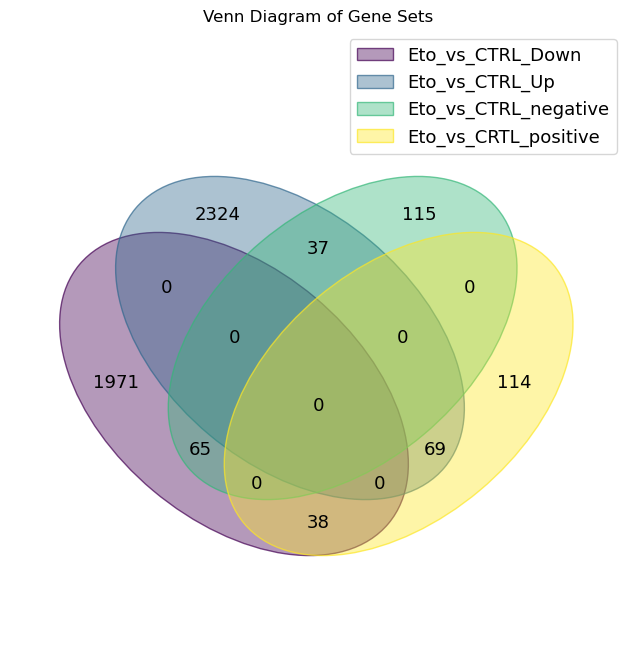

In [26]:
import pandas as pd
from venn import venn
import matplotlib.pyplot as plt

data = df.loc[:, ['Eto_vs_CTRL_Down', 'Eto_vs_CTRL_Up', 'Eto_vs_CTRL_negative', 'Eto_vs_CRTL_positive']]

sets = {col: set(data[col].dropna()) for col in data.columns}

venn(sets)
plt.title('Venn Diagram of Gene Sets')
plt.savefig('venn_diagram.png')

plt.show()

In [33]:
pip install upsetplot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=UpSetPlot-0.9.0-py3-none-any.whl size=24815 sha256=d6dfec19bc0ae6b3d96e13e27804b5217f81577f6b342bf3583f4ae9dd7f8461
  Stored in directory: /Users/mortezaabyadeh/Library/Caches/pip/wheels/d5/0b/03/a5c18ed188619e137e6f170bdb21d745dcf5507cf0d5a2950b
Successfully built upsetplot
Note: you may need to restart the kernel to use updated packages.
